# Background substraction

In [80]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [81]:
def show_image(image):
    plt.figure(figsize=(10, 10), dpi=80)
    plt.imshow(image, cmap='gray', vmin=0, vmax=255);

In [82]:
def remove_noise(image, size_noise, invert):
    '''
    Removes noise from the grayscale image
    
    Parameters:
        image: Grayscale image
        size_noise: Size of noise
        invert: Invert grayscale image
        
    Returns:
        image_without_noise: Image without noise 
    '''
    if invert:
        image = np.invert(image)
    nlabels, labels, stats, centroids = cv2.connectedComponentsWithStats(image, None, None, None, 8, cv2.CV_32S)
    sizes = stats[1:, -1]
    buffor = np.zeros((labels.shape), np.uint8)

    for i in range(0, nlabels - 1):
        if sizes[i] >= size_noise:   #filter small dotted regions
            buffor[labels == i + 1] = 255
    image_without_noise = cv2.bitwise_not(buffor)
    return image_without_noise

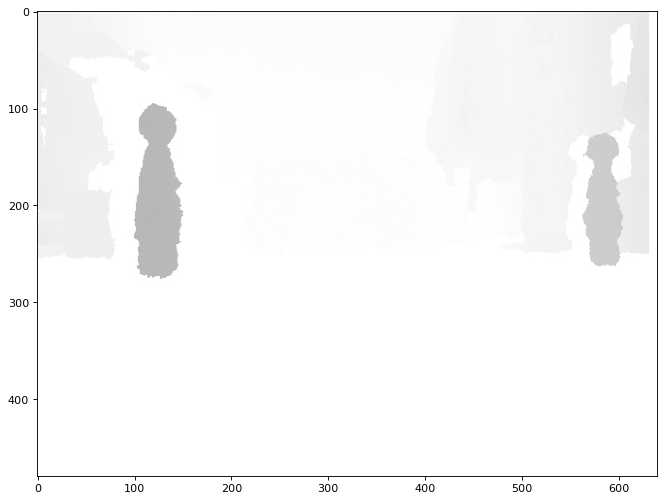

In [83]:
depth_image_without_object = cv2.imread('substraction_1_depth.jpg', cv2.IMREAD_GRAYSCALE)
show_image(depth_image_without_object);

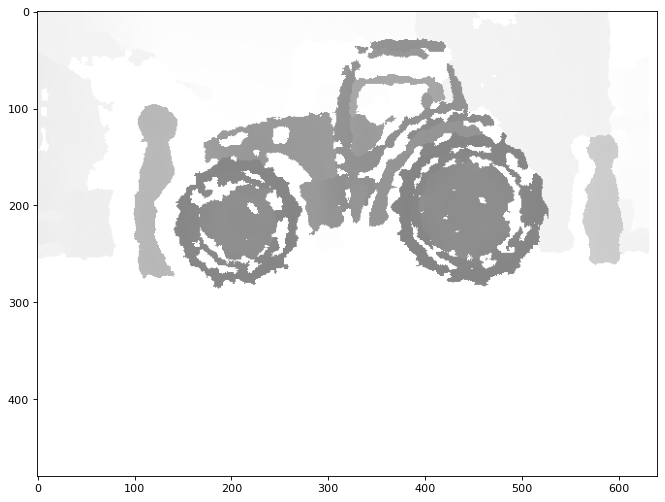

In [84]:
depth_image_with_object = cv2.imread('substraction_2_depth.jpg', cv2.IMREAD_GRAYSCALE)
show_image(depth_image_with_object)

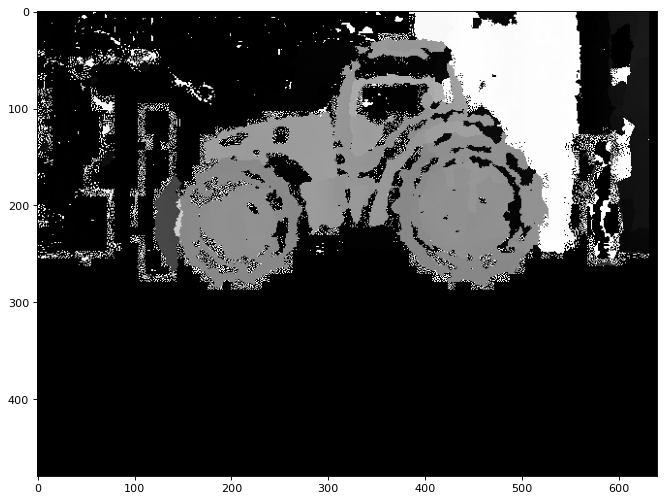

In [85]:
depth_diff = depth_image_with_object - depth_image_without_object
show_image(depth_diff)

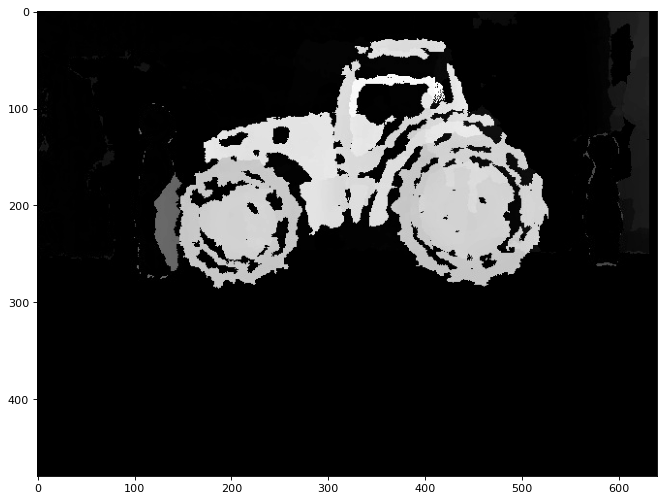

In [86]:
mask = depth_diff.copy()
mask[mask > 175 ] = 0
plt.figure(figsize=(10, 10), dpi=80)
plt.imshow(mask, cmap='gray');

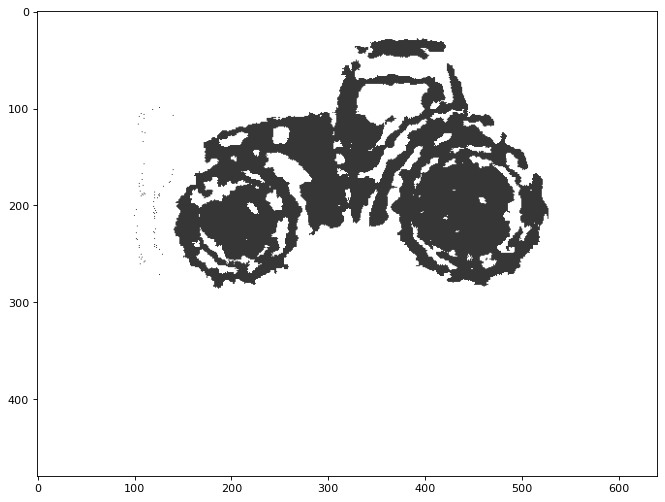

In [87]:
ret, thresh = cv2.threshold(depth_image_with_object, 180, 201, cv2.THRESH_BINARY_INV)
thresh_not = cv2.bitwise_not(thresh)
show_image(thresh_not)

## Remove noise (dots)

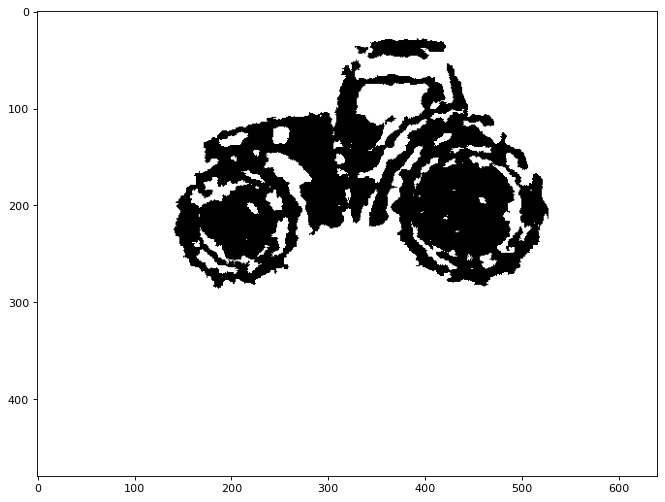

In [88]:
removed_noise = remove_noise(thresh_not, 5, True)
show_image(removed_noise)

# Hole filling

In [89]:
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
"""
 Build an array F and write the Thresh_Not boundary value to F
"""
F = np.zeros(thresh.shape, np.uint8)
F[:, 0] = thresh_not[:, 0]
F[:, -1] = thresh_not[:, -1]
F[0, :] = thresh_not[0, :]
F[-1, :] = thresh_not[-1, :]

In [90]:
for i in range(5000):
    F_dilation = cv2.dilate(F, kernel, iterations=1)
    F = cv2.bitwise_and(F_dilation, removed_noise)

result = cv2.bitwise_not(F)


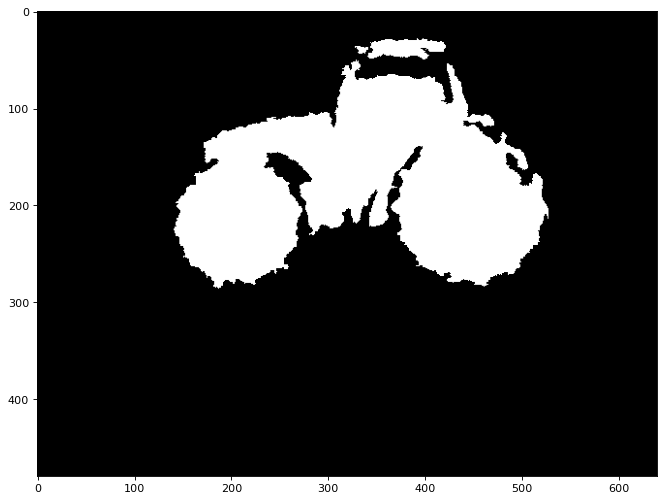

In [91]:
show_image(result)

# Contours after hole filling

In [92]:
contours, _ = cv2.findContours(result, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contours = sorted(contours, key=cv2.contourArea)

In [93]:
rgb_image = cv2.cvtColor(result, cv2.COLOR_GRAY2RGB)

<Figure size 800x800 with 0 Axes>

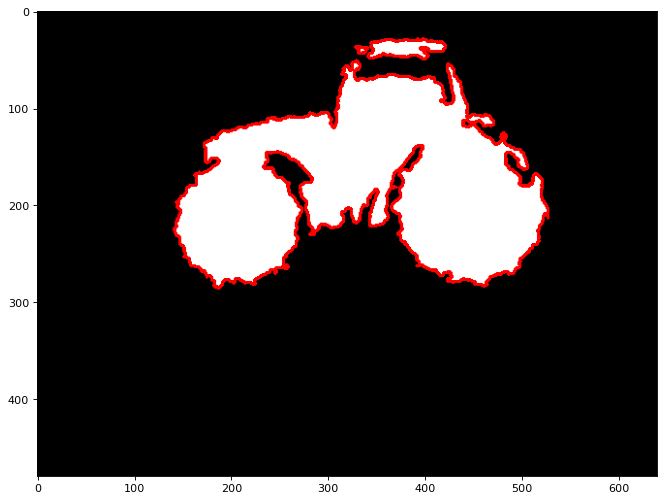

In [94]:
image_with_contours = cv2.drawContours(rgb_image, contours, -1, (255, 0, 0), 2)
plt.figure(figsize=(10, 10), dpi=80)
show_image(image_with_contours)